In [ ]:

!pip install ultralytics supervision -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 645.7/645.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 4.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import supervision as sv
import cv2

from ultralytics import YOLO

model = YOLO('yolov8s.pt')

VIDEO = "video.mp4"

colors = sv.ColorPalette.default()
video_info = sv.VideoInfo.from_video_path(VIDEO)
video_info

VideoInfo(width=720, height=1280, fps=30, total_frames=517)

In [ ]:
# extract video frame
generator = sv.get_video_frames_generator(VIDEO)
iterator = iter(generator)

frame = next(iterator)

# save first frame
cv2.imwrite("first_frame.png", frame)

True

In [ ]:
polygons = [
np.array([
[235, 328],[423, 320],[583, 660],[167, 648]
]),np.array([
[103, 336],[223, 336],[139, 604],[11, 488]
])
]


In [ ]:
# initialize our zones

zones = [
    sv.PolygonZone(
        polygon=polygon,
        frame_resolution_wh=video_info.resolution_wh
    )
    for polygon
    in polygons
]
zone_annotators = [
    sv.PolygonZoneAnnotator(
        zone=zone,
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=8,
        text_scale=4
    )
    for index, zone
    in enumerate(zones)
]
box_annotators = [
    sv.BoxAnnotator(
        color=colors.by_idx(index),
        thickness=4,
        text_thickness=4,
        text_scale=2
        )
    for index
    in range(len(polygons))
]

def process_frame(frame: np.ndarray, i) -> np.ndarray:
    results = model(frame, imgsz=1280, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
        mask = zone.trigger(detections=detections)
        detections_filtered = detections[mask]
        frame = box_annotator.annotate(scene=frame, detections=detections_filtered, skip_label=True)
        frame = zone_annotator.annotate(scene=frame)

    return frame

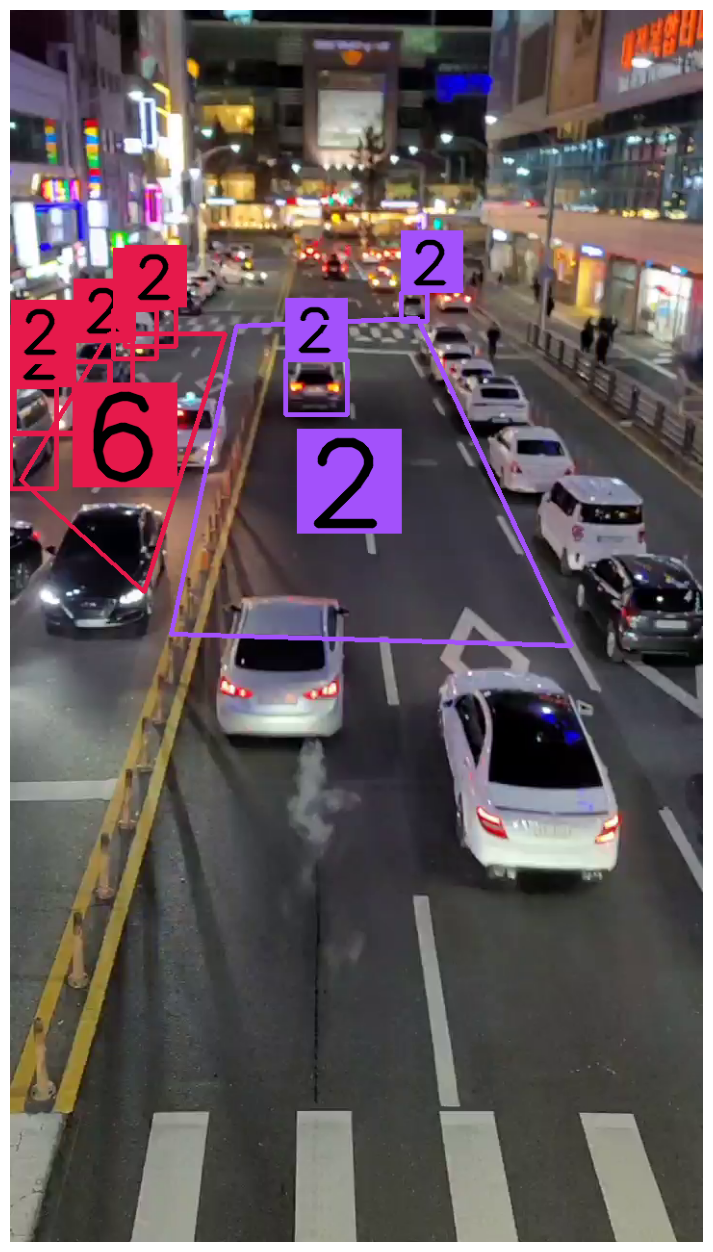

In [ ]:
results = model(frame, imgsz=1280, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

for zone, zone_annotator, box_annotator in zip(zones, zone_annotators, box_annotators):
    mask = zone.trigger(detections=detections)
    detections_filtered = detections[mask]
    frame = box_annotator.annotate(scene=frame, detections=detections_filtered)
    frame = zone_annotator.annotate(scene=frame)

sv.plot_image(frame, (16, 16))

In [ ]:
sv.process_video(source_path=VIDEO, target_path="result.mp4", callback=process_frame)